# Gravitational settling and dry deposition



In [71]:
import matplotlib.pyplot as plt

## eEMEP

non-spherical, F=0.8=(d1+d2)/(2*d3)

In [ ]:
import numpy as np

def potential_temperature(tempC, presPa):
    return (tempC+273.15)*(100000/presPa)**0.286

def monodisperse_terminal_v(diameter,
                            density_p, # kg/m3
                            pot_temp,
                            pressure_mid):

    """
    Calculate monodisperese terminal fall velocity volcanic ash using equations
    as used in Steensen (2017) paper from Zannetti (1990) + cunnigham slip factor + drag
    coefficient for near spherical particles (F=0.8)
    https://gmd.copernicus.org/articles/10/1927/2017/gmd-10-1927-2017.pdf section 2.2.4

    inputs: diameter in [m]
            density_p [kg/m3]
            pot_temp in [K];   array of mid-point pot. temperatures
            pressure_mid [Pa]; array of mid-point pressure levels

    """

    r_specific = 287.050
    kappa = 0.286
    F = 1 # 0.8
    g = 9.81

    temp_abs = pot_temp * np.exp(kappa*np.log(pressure_mid*1e-5))
    density_a = pressure_mid / r_specific / temp_abs

    temp = temp_abs - 273.15 # here in celsius
    zvis = np.empty(np.shape(temperature))

    for index, item in enumerate(temperature): # temperature here in deg. Celsius
        if item >= 0:
            zvis[index] = (1.718 + 0.0049*item)*1e-5 # [Pa s]
        else:
            zvis[index] = (1.718 + 0.0049*item - 1.2e-05*(item**2))*1e-5 # [Pa s]

    # temperature here in Kelvin
    # mean free path of air (Prupp. Klett) in [m], [T] in Kelvin. Eq. 10. 140 2nd edition
    zair = 6.6e-8 * (1013.25 / (pressure_mid * 1e-2)) * (temp_abs / 293.15) # [m]


# combine equations for terminal fall velocity (v), drag coefficient (C_d), and Reynolds number (Re) into
#  a single quadratic expression in v. Equations from doi:10.5194/gmd-10-1927-2017
#
#  v**2 = (4 * g * ( density_p - density_a) * d ) / (3 * C_d * density_a)
#  C_d = (24 / Re) * F**-0.828 + 2 * SQRT(1.07 - F)
#  Re = v * density_a * d / zvis
#
#  Combing the above three expressions yields
#
# [6 * density_a * SQRT(1.07 - F)] * v**2 + [72 * zvis * F**-0.828 / d] * v + [-4 * g * (density_p - density_a) * d] = 0

    quad_a = 6 * density_a * np.sqrt(1.07 - F)
    quad_b = 72 * zvis / diameter * F ** -0.828
    quad_c = -4 * g * (density_p - density_a) * diameter

    zdum = (-quad_b + np.sqrt(quad_b**2 - 4 * quad_a * quad_c)) / (2 * quad_a)

    knut = 2 * zair / diameter
    v_t = zdum * (1 + 1.257 * knut + 0.4 * np.exp(-1.1 / knut)) # m/s

    print(f"temperature = {temperature}")
    print(f"Re = {v_t * density_a * diameter / zvis}")

    return v_t


## SNAP vgrav + constant nu dry deposition

Zannetti (1990) and RAF (1999)

In [104]:

def cun(dp):
    """cunningham factor (Zannetti (1990))
    c = 1 + (2*l/dp)*(a1+a2*exp(-a3*dp/l))

    :param dp: particle size in µm
    """
    a1=1.257
    a2=0.40
    a3=0.55
    l=0.0653
    cun=1.0+(2.0*l/dp)*(a1+a2*np.exp(-a3*dp/l))
    return cun

def visc(temperature):
    """viscosity

    viscosity according to RAFF (1999), Kyle (1991) in poise = g/(cm*s)
    :param temperatur: absolute temp [K]
    """
    return 1.72e-4*(393.0/(temperature+120.0))*(temperature/273.0)**1.5

def rho_air(pressure, temperature):
    """rho air g/cm³

    air density, RAF (1999)
    :param pressure: pressure [hPa]
    :param temperature: aboslute temp [K]
    """
    return 0.001*pressure*100/(287.4 * temperature)

def fit(u,dp,rp,p,t):
    """cunningham slip correction, fit function to iteratively finding correct vgrav from
    Pandis.

    :param u: vg during iteration [cm/s]
    :param dp: diameter µm
    :param rp: density g/cm3
    :param p: pressure hPa
    :param t: abs temp K
    """
    a1 = 0.15
    a2 = 0.687

    u0=vgrav(dp,rp,p,t)
    etha=visc(t)
    re=u*dp*1.0e-4*rho_air(p,t)/etha
    x = u*(1.0+a1*re**a2) - u0
    if(u == 0.0):
        x = -u0
    return x

def iter_vgrav(dp,rp,p,t):
    """iterative procedure to fit vgrav

    :param dp: diameter of particle µm
    :param rp: rho/density particle g/cm3
    :param p: pressure [hPa]
    :param t: absolute temperature [K]

    :return: computed vg

    """
    u0 = vgrav(dp,rp,p,t)
    eps=0.001*u0 # accuracy
    it = 0
    x1 = 0
    x2 = u0
    y1=fit(x1,dp,rp,p,t)
    while it < 100:
        it=it+1
        x=0.5*(x2+x1)
        y=fit(x,dp,rp,p,t)
        if(abs(y) < eps):
            return x
        if (y1*y < 0.0):
            x2 = x
        else:
            x1 = x
            y1=fit(x1,dp,rp,p,t)

    raise RuntimeError(f"cannot find vgrav after {it} iterations: {x,y}")

def vgrav(dp, rp, pressure, temperature):
    """snap vgrav function

    :param dp: particle size [µm]
    :param rp: density [g/cm3]
    :param pressure: [hPa]
    :param temperature: absolute temp [K]
    :return: # cm/s
    """
    g = 981 # cm/s
    return (dp*0.0001)**2 * g*(rp-rho_air(pressure,temperature))*cun(dp) / (18.0*visc(temperature))


def grav_snap(diameter, density_p, temperature, pressure):
    """
    inputs: diameter in [m]
            density_p [kg/m3]
            temperature in [K]; temperatures
            pressure [Pa]; pressure
    outputs: speed in [m/s]
    """

    if type(pressure) is np.ndarray:
        vs = np.empty_like(pressure)
        for i in range(len(pressure)): 
            vs[i] = iter_vgrav(diameter*1e6, density_p/1000, pressure[i]/100, temperature[i])*0.01 #[cm/s -> m/s]
    else:
        vs = iter_vgrav(diameter*1e6, density_p/1000, pressure/100, temperature)*0.01 #[cm/s -> m/s]

    return vs


def aerodynres(L, ustar, z0):
    z = 30
    ka = 0.4
    if (L < 0):
        fac = 0.598 + 0.390 * np.log(-z / L) - 0.09 * (np.log(-z / L)) ** 2
        fi = np.exp(fac)
    elif (L > 0):
        fi = -5 * (z/L)
    else:
        fi = 0

    raero = (1 / (ka * ustar)) * (np.log(z/z0) - fi)
    return raero

def ustarr(surface_stress, roa):
    """_summary_

    :param surface_stress: surface stress [N/m²]
    :param roa: air density kg/m³
    :return: _description_
    """
    return surface_stress/np.sqrt(roa)

def drydep_add_orig(diameter, temperature, pressure, vs, alpha, z0):
    """_summary_

    :param diameter: _description_
    :param temperature: _description_
    :param pressure: Surface air pressure [Pa]
    :param vs: _description_
    :return: _description_
    """

    bolzc = 1.380649e-23
    grav=9.8
    stress = 0.5 #Estimate for surface stress in Oslo. [N/m²]
    # alpha = 1.5 #Alpha in urban environment (Oslo)
    CP = 1005.0
    k = 0.4
    hflux= 10 #Educated estimate for Oslo surface sensible heat flux [W/m²]
    # z0 = 1.0 #for urban (Oslo)

    ny = 1.5e-5  #Kinematic viscosity at + 15 C and 1013.25 hPa [m²/s]

    roa = rho_air(pressure/100, temperature)/0.001  # --> kg/m³ 
    my = ny * roa

    ustar = ustarr(stress, roa)


    cslip = cun(diameter*1e6)
    bdiff = bolzc * temperature * cslip / (3 * np.pi * my *diameter)
    sc = ny/bdiff

    EB = 0.2 * sc **(-2.0/3.0)
    stokes = vs * ustar * ustar/(grav*ny)
    EIM = 0.4 * (stokes / (alpha + stokes))**1.7
    rs = 1.0 / (3.0 * ustar * (EB + EIM))
    
    monin_obukhov_length = - roa * CP * temperature * (ustar**3) / (k * grav * hflux)
    if type(z0) is list or type(z0) is np.ndarray:
        raero = np.empty_like(pressure)
        for i in range(len(pressure)):
            raero[i] = aerodynres(monin_obukhov_length[i], ustar[i], np.real(z0[i]))
    elif type(pressure) is np.ndarray:
        raero = np.empty_like(pressure)
        for i in range(len(pressure)): 
            raero[i] = aerodynres(monin_obukhov_length[i], ustar[i], np.real(z0))
    else:
        raero = aerodynres(monin_obukhov_length, ustar, np.real(z0))

    return 1.0/(raero + rs) 

def dry_dep_const_nu(diameter, density_p, temperature, pressure, alpha, z0):
    """
    inputs: diameter in [m]
            density_p [kg/m3]
            temperature in [C]; temperatures
            pressure_mid [Pa]; pressure
    outputs: speed in [m/s]
    """

    vs = grav_snap(diameter,density_p,temperature, pressure)
    
    drydep = drydep_add_orig(diameter, temperature, pressure, vs, alpha, z0)
    vd_dep = drydep + vs

    return vd_dep

# def gravitational_settling(roa, diam, ro_part):
#     """alternative code implemented for new dry-depositions (surface) - abandoned due to bugs

#     :param roa: air densitiy [kg/m3]
#     :param diam: diameter in [m]
#     :param ro_part: particle density [kg/m3]
#     :return: velocity in [m/s]
#     """
#     # mean free path in air [m]
#     lam = 0.065e-6
#     # gravity [m/s]
#     grav = 9.8
#     # Kinematic viscosity of air, m2 s-1 at +15 C
#     ny = 1.5e-5

#     my = ny * roa
#     fac1 = -0.55 * diam / lam
#     cslip = 1 + 2 * lam / diam * ( 1.257 + 0.4 * np.exp(fac1) )

#     vs = ro_part * diam * diam * grav * cslip / (18*my)
#     return vs

## Gravitational settling: eEMEP vs. SNAP

temperature = [ 15.  -56.5 -56.5]
Re = [5.56218727e-06 3.66470328e-06 1.95522243e-06]
diam.: 1, v_t: [0.00029284 0.00050856 0.0011216 ]
size: 1, vt=[8.11338877e-05 1.02686524e-04 1.02698828e-04]
temperature = [ 15.  -56.5 -56.5]
Re = [0.00485937 0.00244474 0.00068849]
diam.: 10, v_t: [0.02558343 0.03392643 0.03949469]
size: 10, vt=[0.00706285 0.00895657 0.00896641]
temperature = [ 15.  -56.5 -56.5]
Re = [0.03853462 0.01904221 0.0049944 ]
diam.: 20, v_t: [0.10143784 0.13212722 0.14325093]
size: 20, vt=[0.02769357 0.0352588  0.03547168]
temperature = [ 15.  -56.5 -56.5]
Re = [0.59198478 0.2910375  0.07316028]
diam.: 50, v_t: [0.62333198 0.80776275 0.83936149]
size: 50, vt=[0.159253   0.20891037 0.21628924]
temperature = [ 15.  -56.5 -56.5]
Re = [4.3694378  2.22208346 0.56654038]
diam.: 100, v_t: [2.30040571 3.08365119 3.24993415]
size: 100, vt=[0.5158724  0.72027397 0.80846189]
temperature = [ 15.  -56.5 -56.5]
Re = [24.76989748 14.17436011  4.15958294]
diam.: 200, v_t: [ 6.52038275  9.8

Text(0.5, 1.0, 'SNAP scheme')

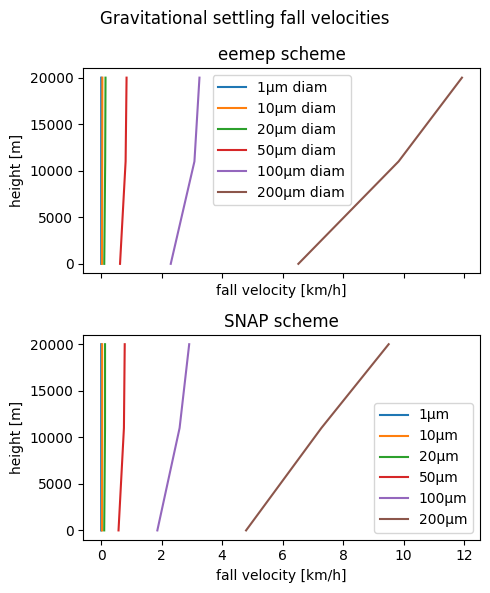

In [ ]:
colours = ['black','blue', 'orange', 'green', 'red', 'purple']

std_atmosphere = {
    "height": np.array([0., 11000., 20000.]),
    "pressure": np.array([101325., 22632., 5475.]),
    "temperature": np.array([15., -56.5, -56.5]),
}

pot_temp = potential_temperature(presPa=std_atmosphere["pressure"], tempC=std_atmosphere["temperature"])

fig, ax = plt.subplots(2,1, figsize=(5,6),layout="tight", sharex=True)
fig.suptitle("Gravitational settling fall velocities")
i=0
for psize in [1, 10, 20, 50, 100, 200]:
    fall_velocities = monodisperse_terminal_v(psize*1e-6,
                                            2300,
                                            pot_temp,
                                            std_atmosphere["pressure"])
    ax[0].plot(fall_velocities*3.6, std_atmosphere["height"],label=f"{psize}µm diam")
    i+= 1
    print(f"diam.: {psize}, v_t: {fall_velocities*3.6}")
    fall_velocities = grav_snap(psize*1e-6,
                                2300,
                                std_atmosphere["temperature"]+273.15,
                                std_atmosphere["pressure"])
    ax[1].plot(fall_velocities*3.6, std_atmosphere["height"],label=f"{psize}µm")
    print(f"size: {psize}, vt={fall_velocities}")
ax[0].legend()
ax[0].set(xlabel='fall velocity [km/h]', ylabel="height [m]")
ax[0].set_title("eemep scheme")
ax[1].legend()
ax[1].set(xlabel='fall velocity [km/h]', ylabel="height [m]")
ax[1].set_title("SNAP scheme")

## Dry Deposition: SNAP variable nu scheme

In [102]:
def rho_air2(pressure, temperature): #in drypdep AND vgrav
    """rho air kg/m³

    air density, RAF (1999)
    :param pressure: pressure [hPa]
    :param temperature: aboslute temp [K]
    """
    return pressure*100/(287.05 * temperature)

def nu(my, rho):  #in drydep 
    """Kinematic viscosity of air

    :param my: Dynamic viscosity [kg/(m s)]
    :param rho: Air density [kg/m³]
    :return: Kinematic viscosity [m²/s]
    """
    ny = my/rho
    return ny


def iter_vgrav2(dp,rp,p,t): #In vgrav - cgs
    """iterative procedure to fit vgrav

    :param dp: diameter of particle µm
    :param rp: rho/density particle g/cm3
    :param p: pressure [hPa]
    :param t: absolute temperature [K]

    :return: computed vg [cm/s]

    """


    u0 = vgrav2(dp,rp,p,t) # [cm/s]
    eps=0.001*u0 # accuracy
    it = 0
    x1 = 0
    x2 = u0
    y1=fit(x1,dp,rp,p,t)
    while it < 100:
        it=it+1
        x=0.5*(x2+x1)
        y=fit(x,dp,rp,p,t)
        if(abs(y) < eps):
            return x
        if (y1*y < 0.0):
            x2 = x
        else:
            x1 = x
            y1=fit(x1,dp,rp,p,t)

    raise RuntimeError(f"cannot find vgrav after {it} iterations: {x,y}")



def vgrav2(dp, rp, pressure, temperature): #in vgrav - cgs
    """snap vgrav function

    :param dp: particle size [µm]
    :param rp: density [g/cm3]
    :param pressure: [hPa]
    :param temperature: absolute temp [K]
    :return: cm/s
    """
    g = 981 # cm/s² 
    return (dp*0.0001)**2 * g*(rp-(rho_air2(pressure,temperature)*1e-3))*cun(dp) / (18.0*visc(temperature))


def aerodynres2(L, ustar, z0): #in drydep
    z = 30
    ka = 0.4
    if (L < 0):
        fac = 0.598 + 0.390 * np.log(-z / L) - 0.09 * (np.log(-z / L)) ** 2
        fi = np.exp(fac)
    elif (L > 0):
        fi = -5 * (z/L)
    else:
        fi = 0

    raero = (1 / (ka * ustar)) * (np.log(z/z0) - fi)
    return raero

def grav_snap2(diameter, density_p, temperature, pressure):

    """
    inputs: diameter in [m]
            density_p [kg/m3]
            temperature in [K]; temperatures
            pressure_mid [Pa]; pressure
    outputs: speed in [m/s]
    """

    if type(pressure) is np.ndarray:
        vs = np.empty_like(pressure)
        for i in range(len(pressure)): 
            vs[i] = iter_vgrav2(diameter*1e6, density_p/1000, pressure[i]/100, temperature[i])*0.01 #[cm/s -> m/s]
    else:
        vs = iter_vgrav2(diameter*1e6, density_p/1000, pressure/100, temperature)*0.01 #[cm/s -> m/s]

    return vs

def drydep_addition(diameter, temperature, pressure, vs, alpha,z0):
    """_summary_

    :param diameter: particle diameter [m]
    :param temperature: Surface air temperature [K]
    :param pressure: surface air pressure [Pa]
    :param vs: Gravitational settling velocity [m/s]
    :return: Surface deposition velocity [m/s]
    """
    
    bolzc = 1.380649e-23  # Boltzmann constant [J/K]
    grav=9.8 # Gravitational acceleration [m/s]
    stress = 0.5 #Estimate for surface stress in Oslo. [N/m²]
    # alpha = 1.5 #Alpha in urban environment (Oslo)
    CP = 1005.0
    k = 0.4
    hflux= 10 #Educated estimate for Oslo surface sensible heat flux [W/m²]
    # z0 = 1.0 #for urban (Oslo)

    my = visc(temperature)/10 #--> kg/m³ 
    roa = rho_air2(pressure/100, temperature) #kg/m³ 
    ny = nu(my,roa)
    ustar = ustarr(stress, roa) 


    cslip = cun(diameter*1e6)
    bdiff = bolzc * temperature * cslip / (3 * np.pi * my *diameter)
    sc = ny/bdiff
    EB = 0.2 * sc **(-2.0/3.0)
    stokes = vs * ustar * ustar/(grav*ny)
    EIM = 0.4 * (stokes / (alpha + stokes))**1.7
    rs = 1.0 / (3.0 * ustar * (EB + EIM))
    
    monin_obukhov_length = - roa * CP * temperature * (ustar**3) / (k * grav * hflux)
    if type(z0) is list or type(z0) is np.ndarray:
        raero = np.empty_like(pressure)
        for i in range(len(pressure)):
            raero[i] = aerodynres2(monin_obukhov_length[i], ustar[i], np.real(z0[i]))
    elif type(pressure) is np.ndarray:
        raero = np.empty_like(pressure)
        for i in range(len(pressure)):
            raero[i] = aerodynres2(monin_obukhov_length[i], ustar[i], np.real(z0))
    else:
        raero = aerodynres(monin_obukhov_length, ustar, np.real(z0))
    

    return 1.0/(raero + rs)

def dry_dep_var_nu(diameter, density_p, temperature, pressure, alpha, z0):
    """
    inputs: diameter in [m]
            density_p [kg/m3]
            temperature in [K]; temperatures
            pressure [Pa]; pressure
    outputs: deposition speed in [m/s]
    """
    vs_settle = grav_snap2(diameter, density_p, temperature, pressure)
    drydep = drydep_addition(diameter, temperature, pressure, vs_settle, alpha, z0)
    vd_dep = drydep + vs_settle

    return vd_dep



### Urban environment

In [78]:
alpha = 1.5
z0 = 1.0 

/tmp/ipykernel_1992458/3718967205.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[2].legend()


[Text(0.5, 0, 'Temperature [C]'),
 Text(0, 0.5, 'Relatie difference in dry dep velocity')]

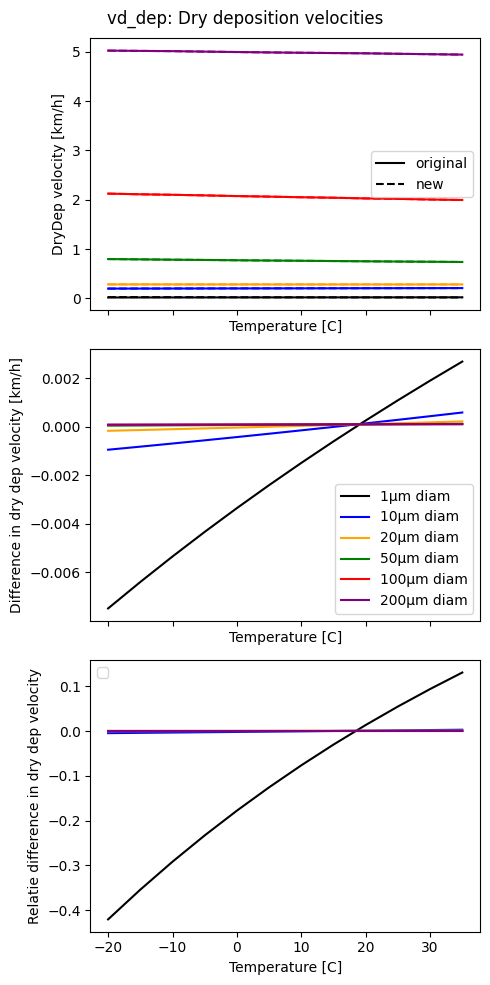

In [93]:
temp = np.arange(-20.0,40.0,5.0)
pressure = np.empty_like(temp)
pressure[:] = std_atmosphere["pressure"][0]

fig,ax = plt.subplots(3,1,figsize=(5,10), layout="tight",sharex=True)
fig.suptitle("vd_dep: Dry deposition velocities")

i=0

for psize in [1, 10, 20, 50, 100, 200]:

    const_nu = dry_dep_const_nu(psize*1e-6,2300,temp + 273.15, pressure,alpha,z0)*3.6
    var_nu = dry_dep_var_nu(psize*1e-6,2300,temp + 273.15, pressure, alpha, z0)*3.6

    if psize ==1:
        ax[0].plot(temp, const_nu, colours[i], label="original")
        ax[0].plot(temp, var_nu, colours[i],linestyle='--', label="new")
    else:
        ax[0].plot(temp, const_nu,color=colours[i])
        ax[0].plot(temp, var_nu, linestyle= '--',color=colours[i])            
    i+=1
ax[0].legend()
ax[0].set(ylabel='DryDep velocity [km/h]', xlabel="Temperature [C]")

i=0
for psize in [1, 10, 20, 50, 100, 200]:
    const_nu = dry_dep_const_nu(psize*1e-6,2300,temp + 273.15, pressure, alpha, z0)*3.6
    var_nu = dry_dep_var_nu(psize*1e-6,2300,temp + 273.15, pressure, alpha, z0)*3.6

    ax[1].plot(temp,const_nu-var_nu,color=colours[i], label=f"{psize}µm diam")

    ax[2].plot(temp,((const_nu-var_nu)/const_nu),color=colours[i])
    i+=1
ax[1].legend()
ax[1].set(xlabel='Temperature [C]', ylabel="Difference in dry dep velocity [km/h]")

ax[2].legend()
ax[2].set(xlabel='Temperature [C]', ylabel="Relatie difference in dry dep velocity")

### Different environments at 1µm

In [94]:
def charnock_z0(ustar,nu):
    alpha_ch = 0.018  # charnock coefficient
    alpha_m = 0.11  # momentum transfer coefficient
    grav = 9.8

    return alpha_m*nu/ustar + alpha_ch*ustar*ustar/grav

Hello!
<class 'numpy.ndarray'>


[Text(0.5, 0, 'Temperature [C]'),
 Text(0, 0.5, 'Relative difference in dry dep velocity')]

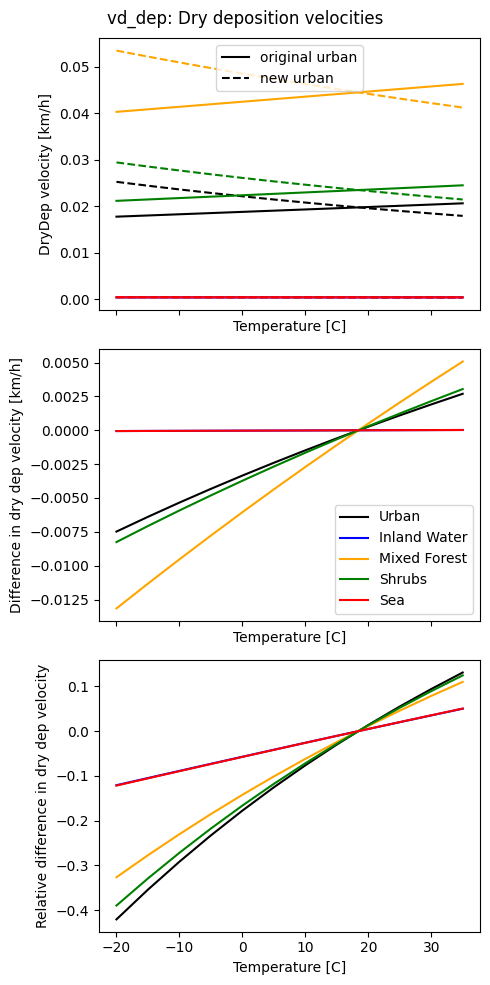

In [109]:
fig, ax = plt.subplots(3,1,figsize=(5,10),layout="tight", sharex=True)
fig.suptitle("vd_dep: Dry deposition velocities")

temp=np.arange(-20.0,40.0,5.0)
pressure = np.empty_like(temp)
pressure[:] = std_atmosphere["pressure"][0]

Environ_list = ["Urban", "Inland Water", "Mixed Forest", "Shrubs", "Sea"]
alpha_list = [1.5, 100 , 0.8, 1.3, 100]  #Urban,Inland Water, Mixed Forest, Shrubs, Sea
z0_list = [1.0, 0.00001, 1.0, 0.5, None]  #Urban, Inland Water, Mixed Forest, Shrubs, Sea

psize = 1  #1 micrometre


i=0

for i  in range(len(alpha_list)):
    # if i == 1 or i == 4:
    alpha = alpha_list[i]
    z0 = z0_list[i]
    if z0 is None:
        print("Hello!")
        my = visc(temp + 273.15)/10 #--> kg/m³ 
        roa = rho_air2( pressure/100, temp + 273.15) #kg/m³ 
        ny = nu(my,roa)
        z0 = charnock_z0(ustarr(0.5, ny), ny)
        print(type(z0))

    const_nu = dry_dep_const_nu(psize*1e-6,2300,temp + 273.15, pressure, alpha, z0)*3.6
    var_nu = dry_dep_var_nu(psize*1e-6,2300,temp + 273.15, pressure, alpha, z0)*3.6

    if i ==0:
        ax[0].plot(temp, const_nu, color=colours[i], label="original urban")
        ax[0].plot(temp, var_nu, '--', color=colours[i], label="new urban")
    else:
        ax[0].plot(temp, const_nu,color=colours[i])
        ax[0].plot(temp, var_nu, "--",color=colours[i])  

    ax[1].plot(temp,const_nu-var_nu,color=colours[i], label=Environ_list[i]) 
    ax[2].plot(temp,((const_nu-var_nu)/const_nu),color=colours[i])         

    i+=1
ax[0].legend()
ax[0].set(ylabel='DryDep velocity [km/h]', xlabel="Temperature [C]")


ax[1].legend()
ax[1].set(xlabel='Temperature [C]', ylabel="Difference in dry dep velocity [km/h]")

ax[2].set(xlabel='Temperature [C]', ylabel="Relative difference in dry dep velocity")

## Dynamic viscosity

### eEMEP
after https://pub.deadnet.se/Books_and_manuals_on_various_stuff/Geology/Microphysics%20of%20Clouds%20and%20Precipitation%202nd%20ed%20-%20H.%20Pruppacher%2C%20J.%20Klett%20%28Kluwer%2C%201997%29%20WW.pdf eq. 10-141a/b

In [ ]:
def visc_eemep(t):
    """dynamic viscosity in poise after Pruppacher-Klett
    Microphysics of Clounds and Precipitaiton, eq. 10-141a/b

    :param t: temperature [°C]
    :return: viscosity in [Pa s = 10 poise]
    """

    if t >= 0:
        vis = (1.718 + 0.0049*t)*1e-5 # [Pa s]
    else:
        vis = (1.718 + 0.0049*t - 1.2e-05*(t**2))*1e-5 # [Pa s]

    return vis


### SNAP



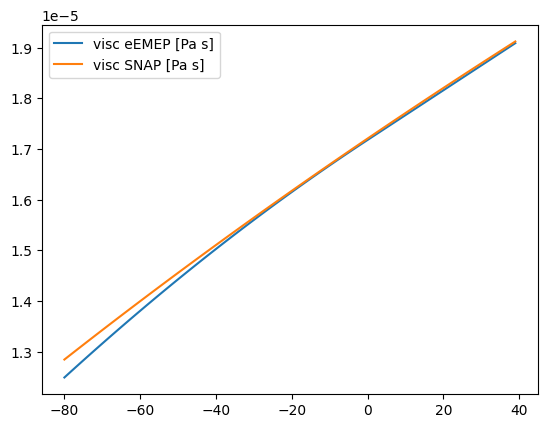

In [ ]:
def visc_snap(t):
    """Dynamic viscosity

    :param t: temperature in K
    :return: dynamic viscosity in kg/(cm s)
    """
    t_K = t+273.15
    visc = 1.72e-4*(393.0/(t_K+120.0))*(t_K/273.0)**1.5 # poise
    return visc/10 # Pa s

temps = np.arange(-80,40,1)
my_eemep = [visc_eemep(t) for t in temps]
plt.plot(temps, my_eemep, label="visc eEMEP [Pa s]")
temps = np.arange(-80,40,1)
my = [visc_snap(t) for t in temps]
plt.plot(temps, my, label="visc SNAP [Pa s]")
plt.legend()
